<a href="https://colab.research.google.com/github/velozo27/TCC-Pedro-Velozo-ENG1132/blob/change-how-image-files-are-retrieved/SRCNN_Comentada.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Imports e definição de Constantes

In [1]:
try:
    from google.colab import files
    from google.colab import drive
    drive.mount("/content/gdrive")
    DATASET_ROOT="/content/gdrive/MyDrive/TCC/datasets"
    !pip install patchify
    # wandb to log system metrics: (check CPU and GPU usage while session is runnig)
    !pip install wandb
    import wandb
    wandb.init()
    
    import save_model_helper

except ModuleNotFoundError:
    DATASET_ROOT="./datasets/"
    # coloquei as dependencias em um arquivo separado
    !pip install -r requirements.txt

import torch
torch.cuda.empty_cache()
from torch import nn
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from torchvision.io import read_image
from PIL import Image
from tqdm import tqdm
import matplotlib.pyplot as plt
import os
import numpy as np
from datetime import datetime
from torchvision.datasets import ImageFolder
from torch.utils.data import Subset
from torchvision.transforms import Compose, ToTensor, Resize
import pandas as pd
import time
import re
from pathlib import Path
import image_patches
import image_helper
import load_model_helper


DATASET_NAME = "Flickr2K"
# DATASET_NAME = "Set14"

# Mudar aqui se for para treinar salvando os dataframes e epochs no drive
# Se True, não pega nem salva nada no drive
EXPERIMENTAL_MODE = True


# Setup device-agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
# garantir que é cuda
# assert device == "cuda"

# https://stackoverflow.com/questions/65734044/kernel-appears-to-have-died-jupyter-notebook-python-matplotlib
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'

# https://stackoverflow.com/a/74952995
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "max_split_size_mb:256"


# Criando os patches

(patches já foram criados, não precisa rodar)

In [2]:
%time
# otimizacao: criar patches de treino, validacao e teste de uma vez: (32, 8, 2)
# image_patches.create_valid_image_patches(f"{DATASET_ROOT}/{DATASET_NAME}", (33, 33, 3), f"{DATASET_ROOT}/{DATASET_NAME}_train", 145)
# image_patches.create_image_patches(f"{DATASET_ROOT}/{DATASET_NAME}", (33, 33, 3), f"{DATASET_ROOT}/{DATASET_NAME}_validation", 20)

CPU times: total: 0 ns
Wall time: 0 ns


# ***SRCNN***

In [3]:
class SRCNN(nn.Module):
    def __init__(self, num_channels=3, use_padding=True, initialization='normal'):
        super(SRCNN, self).__init__()
        self.initialization = initialization
        self.using_padding = use_padding
        padding = [0, 0, 0]
        if use_padding:
            padding = [9 // 2, 5 // 2, 5 // 2]
        self.conv1 = nn.Conv2d(num_channels, 64, kernel_size=9, padding=padding[0])
        self.conv2 = nn.Conv2d(64, 32, kernel_size=5, padding=padding[1])
        self.conv3 = nn.Conv2d(32, num_channels, kernel_size=5, padding=padding[2])

        # self.conv1 = nn.Conv2d(
        #     3, 64, kernel_size=9, padding=(2, 2)
        # )
        # self.conv2 = nn.Conv2d(
        #     64, 32, kernel_size=1, padding=(2, 2)
        # )
        # self.conv3 = nn.Conv2d(
        #     32, 3, kernel_size=5, padding=(2, 2)
        # )
        
        self.relu = nn.ReLU(inplace=True)
        
        # self.apply(self._init_weights)
        # self._init_weights()

    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.relu(self.conv2(x))
        x = self.conv3(x)
        return x
    
    def _init_weights(self):
      # The filter weights of each layer are initialized by drawing randomly 
      # from a Gaussian distribution with zero mean and standard deviation 0.001 (and 0 for biases)
      for module in self.modules():
        if isinstance(module, nn.Conv2d):
          if self.initialization == "normal":
            module.weight.data.normal_(mean=0.0, std=0.001)
          elif self.initialization == "xavier":
            nn.init.xavier_normal_(module.weight.data)
          else:
            nn.init.eye_(module.weight.data)

          if module.bias is not None:
              module.bias.data.zero_()


# Loops de **Treino** e **Validação**

In [4]:
def train_loop(dataloader, model, loss_fn, optimizer, device="cuda" if torch.cuda.is_available() else "cpu"):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)

    print(f"Training on {size} samples...")
    print("Batch size:", dataloader.batch_size)
    print("Number of batches:", num_batches)

    train_loss = 0
    for batch, (X, y) in tqdm(enumerate(dataloader), total=len(dataloader)):
        # X = X.to(device)
        # print("X", X.shape, X.get_device())
        # y = y.to(device)
        # Compute prediction and loss
        pred = model(X)
        # print(pred.shape, pred.get_device())
        loss = loss_fn(pred, y)

        train_loss += loss.item()

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

    train_loss /= num_batches

    # return avg loss
    print(f"Training Error: \n Avg loss: {train_loss:>8f} \n")
    return train_loss

# will also be used for testing (maybe)
def validation_loop(dataloader, model, loss_fn, device="cuda" if torch.cuda.is_available() else "cpu"):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    validation_loss = 0

    with torch.no_grad(), tqdm(total=num_batches) as progress_bar:
        for X, y in dataloader:
            # X = X.to(device)
            # y = y.to(device)
            pred = model(X)
            validation_loss += loss_fn(pred, y).item()
            progress_bar.update(1)

    validation_loss /= num_batches

    print(f"Validation Error: \n Avg loss: {validation_loss:>8f} \n")
    return validation_loss


# CustomImageDataset

In [5]:
class CustomImageDataset(Dataset):
    """
    A PyTorch dataset for loading a directory of images.

    Args:
        img_dir (str): The path to the directory containing the images.
        transform (callable, optional): A function/transform that takes in an image and returns a
            transformed version. Default: None.
        target_transform (callable, optional): A function/transform that takes in the target and
            transforms it. Default: None.
    """

    def __init__(self, img_dir: str, patches_per_image = None | int, transform = None, target_transform = None, use_patches = True, device="cuda" if torch.cuda.is_available() else "cpu" ):
        """
        Initializes a new instance of the CustomImageDataset class.

        Args:
            img_dir (str): The path to the directory containing the images.
            transform (callable, optional): A function/transform that takes in an image and returns a
                transformed version. Default: None.
            target_transform (callable, optional): A function/transform that takes in the target and
                transforms it. Default: None.
        """
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform
        self.patches_per_image = patches_per_image
        self.device = device
        
        self.file_list_tensor = self.create_tensors_from_images()
        self.file_list_tensor.to(device)

    def create_tensors_from_images(self):
      number_of_images = self._get_number_of_images_in_folder(f"{self.img_dir}/patches")

      # creating the empty tensor
      image_tensors = torch.empty((number_of_images, 3, 33, 33))

      current_tensor_index = 0

      all_patches_dir = f"{self.img_dir}/patches"

      if not os.path.exists(all_patches_dir) or not os.path.isdir(all_patches_dir):
          return list(os.listdir(self.img_dir))

      for patch_path in tqdm(list(os.listdir(all_patches_dir))):
        one_patch_full_dir = f"{all_patches_dir}/{patch_path}"
        one_path_relative_dir = f"patches/{patch_path}"
        
        patches_list = list(os.listdir(one_patch_full_dir))
        
        for index, patch in enumerate(patches_list):
          image_path = f"{one_path_relative_dir}/{patch}"

          if self._check_if_image_is_not_corrupted(image_path):
            continue
          
          image_as_tensor = read_image(f"{self.img_dir}/{image_path}")

          # updating the created tensor
          image_tensors[current_tensor_index] = image_as_tensor.float() / 255

          current_tensor_index += 1
                    
      return image_tensors


    def __len__(self) -> int:
        """
        Returns the number of images in the dataset.

        Returns:
            The number of images in the dataset.
        """
        return self._get_number_of_images_in_folder(f"{self.img_dir}/patches")

    def __getitem__(self, idx: int) -> tuple[torch.Tensor, torch.Tensor]:
        """
        Returns the image at the specified index in the dataset.

        Args:
            idx (int): The index of the image to return.

        Returns:
            A tuple containing the transformed input image and the transformed target image.
        """
    
        image = self.file_list_tensor[idx]
        # image_x = image.detach().clone()
        # image_y = image.detach().clone()

        image_x = image.to(self.device)
        image_y = image.to(self.device)
        
        if self.transform:
            # image_x = self.transform(image_x)
            image_x = self.transform(image)
            # image_x = self.transform(image).to(device)
        if self.target_transform:
            #image_y = self.target_transform(image_y)
            image_y = self.target_transform(image)
            # image_y = self.target_transform(image).to(device)
            
          
        return image_x.to(self.device), image_y.to(self.device)

    def _get_number_of_images_in_folder(self, dir: str):
      """
      Gets the total number of all the patches
      """
      all_patches_dir = f"{self.img_dir}/patches"
      if not os.path.exists(all_patches_dir) or not os.path.isdir(all_patches_dir):
          return list(os.listdir(self.img_dir))

      number_of_images = 0
      for patch_path in list(os.listdir(all_patches_dir)):
        one_patch_full_dir = f"{all_patches_dir}/{patch_path}"
        one_path_relative_dir = f"patches/{patch_path}"
        
        patches_list = list(os.listdir(one_patch_full_dir))
        
        for index, patch in enumerate(patches_list):
          image_path = f"{one_path_relative_dir}/{patch}"

          if self._check_if_image_is_not_corrupted(image_path):
            continue

          number_of_images += 1

      return number_of_images

    def _check_if_image_is_not_corrupted(self, image_path: str) -> bool:
      """
      Returns True if the file is corrupted else returns False
      """
      file_size = Path(f"{self.img_dir}/{image_path}").stat().st_size

      if file_size == 0:
        print(f"Error loading image file: {self.img_dir}/{image_path}. Reason: file has size 0")
        return True
      
      return False

# Criando os ***Dataset*'s**

In [6]:
%%time
transform_x = transforms.Compose([
    # downscale by factor of 3 (from 33x33 to 11x11 back to 33x33)
    # resize image to 11x11 and downsample by BICUBIC interpolation
    transforms.Resize((11, 11), interpolation=Image.BICUBIC),
    # resize image to 33x33
    transforms.Resize((33, 33), interpolation=Image.BICUBIC)
    # transforms.CenterCrop((33, 33))
])

transform_y = transforms.Compose([
    ##transforms.Resize((33, 33), interpolation=Image.BICUBIC)
    #transforms.CenterCrop((21, 21))
    transforms.CenterCrop((17, 17))
    # transforms.CenterCrop((25, 25))
    # transforms.CenterCrop((33, 33))
])

# Set up the data loaders
train_data_set = CustomImageDataset(
    img_dir=f"{DATASET_ROOT}/{DATASET_NAME}_train", transform=transform_x, target_transform=transform_y)
validation_data_set = CustomImageDataset(
    img_dir=f"{DATASET_ROOT}/{DATASET_NAME}_validation", transform=transform_x, target_transform=transform_y)

# # Report split sizes
print('Training set has {} instances'.format(len(train_data_set)))
print('Validation set has {} instances'.format(len(validation_data_set)))

100%|██████████| 2650/2650 [00:42<00:00, 61.75it/s]


Training set has 162186 instances
Validation set has 53000 instances
CPU times: total: 19 s
Wall time: 3min 35s


In [7]:
%%time

# https://towardsdatascience.com/7-tips-for-squeezing-maximum-performance-from-pytorch-ca4a40951259
pin_memory = False
batch_size = round(0.6*(2**13))
# batch_size = 2**13

train_dataloader = DataLoader(train_data_set, batch_size=batch_size, shuffle=True, pin_memory=pin_memory) # TODO: aumentar batch_size p/ 2^12
validation_dataloader = DataLoader(validation_data_set, batch_size=batch_size, pin_memory=pin_memory)

CPU times: total: 19.8 s
Wall time: 26.6 s


In [8]:
# save dataloader (https://discuss.pytorch.org/t/how-to-save-dataloader/62813/4)
# torch.save(train_dataloader, 'train_dataloader.pth')
# torch.save(train_dataloader, 'validation_dataloader.pth')

# Instanciando o modelo

In [9]:
# Instancianting the model
# Atencao: cuidado ao rodar o treino várias vezes sem resetar o modelo!
# model = SRCNN(initialization="normal")
# model.to(device)

In [10]:
# model = SRCNN(num_channels=3)
# model.to(device)

In [11]:
# img = image_patches.get_image_patch(f"{DATASET_ROOT}/{DATASET_NAME}_train").float()/255
# print(type(img), img.shape, img.dtype, img.min(), img.max())
# with torch.no_grad():
#   img_out = model(img.unsqueeze(0).to(device))
# print(type(img_out), img_out.shape, img_out.dtype, img_out.min(), img_out.max())
# # plt.figure()
# # plt.subplot(1, 2, 1)
# # plt.imshow(ImageHelperInstance.tensor_as_image(img.cpu()))
# # plt.subplot(1, 2, 2)
# # plt.imshow(ImageHelperInstance.tensor_as_image(img_out.squeeze().cpu()))
# # plt.show()

In [12]:
# plt.figure()
# plt.subplot(1, 2, 1)
# plt.imshow(image_helper.tensor_as_image(img.cpu()))
# plt.subplot(1, 2, 2)
# plt.imshow(image_helper.tensor_as_image(img_out.squeeze().cpu()))
# plt.show()

# Criando o *Optmizer* e a *loss function* (MSE)

In [13]:
# otimizacao: Mudar o otimizador para Adam ou RMSProp
#           : Usar momentum = 0.9
#           : Usar learning maior: 1e-4?
#           : Usar learning rate decay

# hyperparameters
#https://stackoverflow.com/questions/48324152/pytorch-how-to-change-the-learning-rate-of-an-optimizer-at-any-given-moment-no
lr = 1e-3
model = SRCNN(num_channels=3, use_padding=False)
model.to(device)

# CARREGANDO MODELO TREINADO
# model = SRCNN(num_channels=3).to(device)
# try:
#     model.load_state_dict(torch.load('./srcnn_03_07-v4.pth'))
# except:
#     model.load_state_dict(torch.load('./srcnn_03_07-v4.pth', map_location=torch.device('cpu')))

# 3.3 Training
# The loss is minimized using stochastic gradient descent with the standard backpropagation
# optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=0.9)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

# scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
#     optimizer,
#     mode='min',
#     factor=0.1,
#     patience=2,
#     threshold=1e-3,
#     verbose=True
#     )
scheduler = torch.optim.lr_scheduler.LinearLR(
    optimizer,
    start_factor=1.0,
    end_factor=0.01,
    # end_factor=1.0,
    total_iters=100)
# we use Mean Squared Error (MSE) as the loss function:
loss_fn = nn.MSELoss()
loss_fn.to(device)

MSELoss()

# **Treinamento** 

## Execução das *epochs*
- Execução dos loops de treinamento e validação, e também salvamentos dos dados

In [14]:
# starting_epoch = load_model_helper.get_epoch_number_from_path(model_load_path_name)
# if starting_epoch is not None:
#   starting_epoch = starting_epoch + 1 # add 1 because we are starting after the epoch we left of
# print('starting_epoch =', starting_epoch)
starting_epoch = 0


In [15]:
# lr = 0.00001
# optimizer.param_groups[0]['lr'] = lr
# scheduler = torch.optim.lr_scheduler.LinearLR(
#     optimizer,
#     start_factor=1.0,
#     end_factor=0.1,
#     total_iters=5)

In [16]:
# train_loss_array2 = []
# for x in train_loss_array:
#     train_loss_array2.append(x)
    
# validation_loss_array2 = []
# for x in validation_loss_array:
#     validation_loss_array2.append(x)
    
# print(len(train_loss_array2))
# print(len(validation_loss_array2))

In [17]:
# train_loss_array3 = train_loss_array2
# validation_loss_array3 = validation_loss_array2

In [18]:
# epoch_array_copy = epoch_array
# time_array_copy = time_array
# lr_array_copy = lr_array

In [19]:
# epoch_array = epoch_array[:-2]
# time_array = time_array[:-2]
# lr_array = lr_array[:-2]

# print(len(time_array))

In [20]:
# df = pd.read_csv('./srcnn_03_07-v4.csv')
# last_index = df.index[-1]
# current_epoch = df['epoch'][last_index] + 1
# print('current_epoch =', current_epoch)
# df.tail()

In [21]:
epoch_array = []
time_array = []
lr_array = []
train_loss_array = []
validation_loss_array = []

# # check if df is not empty
# if df is not None and df['Train Loss'].any():
#     train_loss_array = df['Train Loss'].to_list()
#     validation_loss_array = df['Validation Loss'].to_list()
#     epoch_array = df['epoch'].to_list()
#     time_array = df['epoch_duration [s]'].to_list()
#     lr_array = df['learning rate'].to_list()

In [22]:
print('train_loss_array =', train_loss_array)
print('validation_loss_array =', validation_loss_array)
print('epoch_array =', epoch_array)
print('time_array =', time_array)
print('lr_array =', lr_array)


train_loss_array = []
validation_loss_array = []
epoch_array = []
time_array = []
lr_array = []


In [23]:
current_epoch = 0
model_test = SRCNN(num_channels=3, use_padding=False)

input_1 = torch.randn([3, 33, 33])
print(input_1.shape)

output_1 = model_test(input_1)
print(output_1.shape)

torch.Size([3, 33, 33])
torch.Size([3, 17, 17])


In [24]:
%%time
train_loss = 0
validation_loss = 0
epochs = 150

######
# epoch_array = []
# time_array = []
# lr_array = []
######

# melhor usar lista e depois converter para array
# train_loss_array = list()
# validation_loss_array = list()
for index, t in enumerate(range(epochs)):
    print(f"\nepoch {current_epoch}\n-------------------------------")

    start_time = time.time()  # Start timing the epoch

    train_loss = train_loop(train_dataloader, model, loss_fn, optimizer)
    validation_loss = validation_loop(validation_dataloader, model, loss_fn)

    # changes the learning rate when the validation loss stops decreasing
    #scheduler.step(validation_loss)
    print(f"Learning rate (antes): {optimizer.param_groups[0]['lr']}")
    scheduler.step()
    print(f"Learning rate (depois): {optimizer.param_groups[0]['lr']}")
    
    train_loss_array.append(train_loss)
    validation_loss_array.append(validation_loss)

    elapsed_time = time.time() - start_time  # Calculate elapsed time for the epoch
    
    ######
    epoch_array.append(current_epoch)
    time_array.append(elapsed_time)
    lr_array.append(optimizer.param_groups[0]['lr'])
    ######
    
    # updating learning rate
    # if current_epoch % 10 == 0 and current_epoch > 0:
    #     optimizer.param_groups[0]['lr'] /= 2

    current_epoch += 1
    
    if not EXPERIMENTAL_MODE:
      df_path = '/content/gdrive/My Drive/TCC/code/models/SRCNN/testing/train_session_testing/SRCNN_train_vs_validation_loss.csv'
      save_model_helper.save_df(df_path, train_loss, validation_loss, current_epoch, elapsed_time)
      save_model_helper.save_epoch(current_epoch, train_loss, validation_loss)
    
print("Done!")


epoch 0
-------------------------------
Training on 162186 samples...
Batch size: 4915
Number of batches: 33


  0%|          | 0/33 [00:00<?, ?it/s]C:\Users\Pedro\anaconda3\lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
100%|██████████| 33/33 [05:45<00:00, 10.46s/it]


Training Error: 
 Avg loss: 0.032367 



100%|██████████| 11/11 [00:54<00:00,  4.96s/it]


Validation Error: 
 Avg loss: 0.006408 

Learning rate (antes): 0.001
Learning rate (depois): 0.0009901

epoch 1
-------------------------------
Training on 162186 samples...
Batch size: 4915
Number of batches: 33


100%|██████████| 33/33 [03:49<00:00,  6.94s/it]


Training Error: 
 Avg loss: 0.009680 



100%|██████████| 11/11 [00:50<00:00,  4.60s/it]


Validation Error: 
 Avg loss: 0.004199 

Learning rate (antes): 0.0009901
Learning rate (depois): 0.0009802

epoch 2
-------------------------------
Training on 162186 samples...
Batch size: 4915
Number of batches: 33


100%|██████████| 33/33 [03:58<00:00,  7.22s/it]


Training Error: 
 Avg loss: 0.008199 



100%|██████████| 11/11 [00:47<00:00,  4.30s/it]


Validation Error: 
 Avg loss: 0.003796 

Learning rate (antes): 0.0009802
Learning rate (depois): 0.0009703

epoch 3
-------------------------------
Training on 162186 samples...
Batch size: 4915
Number of batches: 33


100%|██████████| 33/33 [03:54<00:00,  7.10s/it]


Training Error: 
 Avg loss: 0.007924 



100%|██████████| 11/11 [00:56<00:00,  5.17s/it]


Validation Error: 
 Avg loss: 0.003680 

Learning rate (antes): 0.0009703
Learning rate (depois): 0.0009604

epoch 4
-------------------------------
Training on 162186 samples...
Batch size: 4915
Number of batches: 33


100%|██████████| 33/33 [04:05<00:00,  7.43s/it]


Training Error: 
 Avg loss: 0.007757 



100%|██████████| 11/11 [00:47<00:00,  4.30s/it]


Validation Error: 
 Avg loss: 0.003719 

Learning rate (antes): 0.0009604
Learning rate (depois): 0.0009505000000000001

epoch 5
-------------------------------
Training on 162186 samples...
Batch size: 4915
Number of batches: 33


100%|██████████| 33/33 [03:44<00:00,  6.81s/it]


Training Error: 
 Avg loss: 0.007598 



100%|██████████| 11/11 [00:46<00:00,  4.27s/it]


Validation Error: 
 Avg loss: 0.003941 

Learning rate (antes): 0.0009505000000000001
Learning rate (depois): 0.0009406000000000001

epoch 6
-------------------------------
Training on 162186 samples...
Batch size: 4915
Number of batches: 33


100%|██████████| 33/33 [04:00<00:00,  7.29s/it]


Training Error: 
 Avg loss: 0.007595 



100%|██████████| 11/11 [00:47<00:00,  4.28s/it]


Validation Error: 
 Avg loss: 0.003481 

Learning rate (antes): 0.0009406000000000001
Learning rate (depois): 0.0009307

epoch 7
-------------------------------
Training on 162186 samples...
Batch size: 4915
Number of batches: 33


100%|██████████| 33/33 [03:51<00:00,  7.01s/it]


Training Error: 
 Avg loss: 0.007436 



100%|██████████| 11/11 [00:46<00:00,  4.22s/it]


Validation Error: 
 Avg loss: 0.003649 

Learning rate (antes): 0.0009307
Learning rate (depois): 0.0009208

epoch 8
-------------------------------
Training on 162186 samples...
Batch size: 4915
Number of batches: 33


100%|██████████| 33/33 [03:33<00:00,  6.46s/it]


Training Error: 
 Avg loss: 0.007506 



100%|██████████| 11/11 [00:49<00:00,  4.48s/it]


Validation Error: 
 Avg loss: 0.003436 

Learning rate (antes): 0.0009208
Learning rate (depois): 0.0009109000000000001

epoch 9
-------------------------------
Training on 162186 samples...
Batch size: 4915
Number of batches: 33


100%|██████████| 33/33 [04:17<00:00,  7.79s/it]


Training Error: 
 Avg loss: 0.007391 



100%|██████████| 11/11 [00:45<00:00,  4.10s/it]


Validation Error: 
 Avg loss: 0.003453 

Learning rate (antes): 0.0009109000000000001
Learning rate (depois): 0.0009010000000000001

epoch 10
-------------------------------
Training on 162186 samples...
Batch size: 4915
Number of batches: 33


100%|██████████| 33/33 [03:41<00:00,  6.71s/it]


Training Error: 
 Avg loss: 0.007366 



100%|██████████| 11/11 [00:50<00:00,  4.57s/it]


Validation Error: 
 Avg loss: 0.003467 

Learning rate (antes): 0.0009010000000000001
Learning rate (depois): 0.0008911000000000001

epoch 11
-------------------------------
Training on 162186 samples...
Batch size: 4915
Number of batches: 33


100%|██████████| 33/33 [03:45<00:00,  6.85s/it]


Training Error: 
 Avg loss: 0.007318 



100%|██████████| 11/11 [00:45<00:00,  4.09s/it]


Validation Error: 
 Avg loss: 0.003442 

Learning rate (antes): 0.0008911000000000001
Learning rate (depois): 0.0008812000000000002

epoch 12
-------------------------------
Training on 162186 samples...
Batch size: 4915
Number of batches: 33


100%|██████████| 33/33 [03:46<00:00,  6.85s/it]


Training Error: 
 Avg loss: 0.007407 



100%|██████████| 11/11 [00:46<00:00,  4.19s/it]


Validation Error: 
 Avg loss: 0.003569 

Learning rate (antes): 0.0008812000000000002
Learning rate (depois): 0.0008713000000000002

epoch 13
-------------------------------
Training on 162186 samples...
Batch size: 4915
Number of batches: 33


100%|██████████| 33/33 [03:41<00:00,  6.73s/it]


Training Error: 
 Avg loss: 0.007288 



100%|██████████| 11/11 [00:45<00:00,  4.13s/it]


Validation Error: 
 Avg loss: 0.003467 

Learning rate (antes): 0.0008713000000000002
Learning rate (depois): 0.0008614000000000001

epoch 14
-------------------------------
Training on 162186 samples...
Batch size: 4915
Number of batches: 33


100%|██████████| 33/33 [04:29<00:00,  8.17s/it]


Training Error: 
 Avg loss: 0.007322 



100%|██████████| 11/11 [00:44<00:00,  4.00s/it]


Validation Error: 
 Avg loss: 0.003994 

Learning rate (antes): 0.0008614000000000001
Learning rate (depois): 0.0008515000000000002

epoch 15
-------------------------------
Training on 162186 samples...
Batch size: 4915
Number of batches: 33


100%|██████████| 33/33 [03:40<00:00,  6.67s/it]


Training Error: 
 Avg loss: 0.007326 



100%|██████████| 11/11 [00:46<00:00,  4.20s/it]


Validation Error: 
 Avg loss: 0.003410 

Learning rate (antes): 0.0008515000000000002
Learning rate (depois): 0.0008416000000000002

epoch 16
-------------------------------
Training on 162186 samples...
Batch size: 4915
Number of batches: 33


100%|██████████| 33/33 [03:43<00:00,  6.78s/it]


Training Error: 
 Avg loss: 0.007309 



100%|██████████| 11/11 [00:47<00:00,  4.36s/it]


Validation Error: 
 Avg loss: 0.003389 

Learning rate (antes): 0.0008416000000000002
Learning rate (depois): 0.0008317000000000002

epoch 17
-------------------------------
Training on 162186 samples...
Batch size: 4915
Number of batches: 33


100%|██████████| 33/33 [03:42<00:00,  6.75s/it]


Training Error: 
 Avg loss: 0.007291 



100%|██████████| 11/11 [00:45<00:00,  4.11s/it]


Validation Error: 
 Avg loss: 0.003500 

Learning rate (antes): 0.0008317000000000002
Learning rate (depois): 0.0008218000000000002

epoch 18
-------------------------------
Training on 162186 samples...
Batch size: 4915
Number of batches: 33


100%|██████████| 33/33 [03:42<00:00,  6.74s/it]


Training Error: 
 Avg loss: 0.007234 



100%|██████████| 11/11 [00:50<00:00,  4.63s/it]


Validation Error: 
 Avg loss: 0.003367 

Learning rate (antes): 0.0008218000000000002
Learning rate (depois): 0.0008119000000000003

epoch 19
-------------------------------
Training on 162186 samples...
Batch size: 4915
Number of batches: 33


100%|██████████| 33/33 [04:03<00:00,  7.38s/it]


Training Error: 
 Avg loss: 0.007288 



100%|██████████| 11/11 [00:48<00:00,  4.42s/it]


Validation Error: 
 Avg loss: 0.003396 

Learning rate (antes): 0.0008119000000000003
Learning rate (depois): 0.0008020000000000002

epoch 20
-------------------------------
Training on 162186 samples...
Batch size: 4915
Number of batches: 33


100%|██████████| 33/33 [03:45<00:00,  6.84s/it]


Training Error: 
 Avg loss: 0.007220 



100%|██████████| 11/11 [00:47<00:00,  4.31s/it]


Validation Error: 
 Avg loss: 0.003359 

Learning rate (antes): 0.0008020000000000002
Learning rate (depois): 0.0007921000000000002

epoch 21
-------------------------------
Training on 162186 samples...
Batch size: 4915
Number of batches: 33


100%|██████████| 33/33 [03:51<00:00,  7.03s/it]


Training Error: 
 Avg loss: 0.007198 



100%|██████████| 11/11 [00:46<00:00,  4.20s/it]


Validation Error: 
 Avg loss: 0.003356 

Learning rate (antes): 0.0007921000000000002
Learning rate (depois): 0.0007822000000000003

epoch 22
-------------------------------
Training on 162186 samples...
Batch size: 4915
Number of batches: 33


100%|██████████| 33/33 [03:44<00:00,  6.81s/it]


Training Error: 
 Avg loss: 0.007211 



100%|██████████| 11/11 [00:46<00:00,  4.21s/it]


Validation Error: 
 Avg loss: 0.003397 

Learning rate (antes): 0.0007822000000000003
Learning rate (depois): 0.0007723000000000002

epoch 23
-------------------------------
Training on 162186 samples...
Batch size: 4915
Number of batches: 33


100%|██████████| 33/33 [03:39<00:00,  6.64s/it]


Training Error: 
 Avg loss: 0.007212 



100%|██████████| 11/11 [00:47<00:00,  4.28s/it]


Validation Error: 
 Avg loss: 0.003407 

Learning rate (antes): 0.0007723000000000002
Learning rate (depois): 0.0007624000000000002

epoch 24
-------------------------------
Training on 162186 samples...
Batch size: 4915
Number of batches: 33


100%|██████████| 33/33 [03:40<00:00,  6.67s/it]


Training Error: 
 Avg loss: 0.007165 



100%|██████████| 11/11 [00:47<00:00,  4.29s/it]


Validation Error: 
 Avg loss: 0.003324 

Learning rate (antes): 0.0007624000000000002
Learning rate (depois): 0.0007525000000000002

epoch 25
-------------------------------
Training on 162186 samples...
Batch size: 4915
Number of batches: 33


100%|██████████| 33/33 [03:41<00:00,  6.72s/it]


Training Error: 
 Avg loss: 0.007175 



100%|██████████| 11/11 [00:49<00:00,  4.46s/it]


Validation Error: 
 Avg loss: 0.003322 

Learning rate (antes): 0.0007525000000000002
Learning rate (depois): 0.0007426000000000003

epoch 26
-------------------------------
Training on 162186 samples...
Batch size: 4915
Number of batches: 33


100%|██████████| 33/33 [03:39<00:00,  6.67s/it]


Training Error: 
 Avg loss: 0.007247 



100%|██████████| 11/11 [00:46<00:00,  4.22s/it]


Validation Error: 
 Avg loss: 0.003407 

Learning rate (antes): 0.0007426000000000003
Learning rate (depois): 0.0007327000000000003

epoch 27
-------------------------------
Training on 162186 samples...
Batch size: 4915
Number of batches: 33


100%|██████████| 33/33 [03:45<00:00,  6.83s/it]


Training Error: 
 Avg loss: 0.007158 



100%|██████████| 11/11 [00:46<00:00,  4.23s/it]


Validation Error: 
 Avg loss: 0.003315 

Learning rate (antes): 0.0007327000000000003
Learning rate (depois): 0.0007228000000000003

epoch 28
-------------------------------
Training on 162186 samples...
Batch size: 4915
Number of batches: 33


100%|██████████| 33/33 [03:42<00:00,  6.75s/it]


Training Error: 
 Avg loss: 0.007121 



100%|██████████| 11/11 [00:45<00:00,  4.15s/it]


Validation Error: 
 Avg loss: 0.003351 

Learning rate (antes): 0.0007228000000000003
Learning rate (depois): 0.0007129000000000003

epoch 29
-------------------------------
Training on 162186 samples...
Batch size: 4915
Number of batches: 33


100%|██████████| 33/33 [03:45<00:00,  6.85s/it]


Training Error: 
 Avg loss: 0.007132 



100%|██████████| 11/11 [00:47<00:00,  4.36s/it]


Validation Error: 
 Avg loss: 0.003361 

Learning rate (antes): 0.0007129000000000003
Learning rate (depois): 0.0007030000000000002

epoch 30
-------------------------------
Training on 162186 samples...
Batch size: 4915
Number of batches: 33


100%|██████████| 33/33 [04:03<00:00,  7.39s/it]


Training Error: 
 Avg loss: 0.007117 



100%|██████████| 11/11 [00:44<00:00,  4.07s/it]


Validation Error: 
 Avg loss: 0.003307 

Learning rate (antes): 0.0007030000000000002
Learning rate (depois): 0.0006931000000000002

epoch 31
-------------------------------
Training on 162186 samples...
Batch size: 4915
Number of batches: 33


100%|██████████| 33/33 [03:47<00:00,  6.89s/it]


Training Error: 
 Avg loss: 0.007134 



100%|██████████| 11/11 [00:47<00:00,  4.28s/it]


Validation Error: 
 Avg loss: 0.003362 

Learning rate (antes): 0.0006931000000000002
Learning rate (depois): 0.0006832000000000002

epoch 32
-------------------------------
Training on 162186 samples...
Batch size: 4915
Number of batches: 33


100%|██████████| 33/33 [03:44<00:00,  6.81s/it]


Training Error: 
 Avg loss: 0.007120 



100%|██████████| 11/11 [00:45<00:00,  4.10s/it]


Validation Error: 
 Avg loss: 0.003347 

Learning rate (antes): 0.0006832000000000002
Learning rate (depois): 0.0006733000000000003

epoch 33
-------------------------------
Training on 162186 samples...
Batch size: 4915
Number of batches: 33


100%|██████████| 33/33 [03:44<00:00,  6.80s/it]


Training Error: 
 Avg loss: 0.007136 



100%|██████████| 11/11 [00:47<00:00,  4.32s/it]


Validation Error: 
 Avg loss: 0.003324 

Learning rate (antes): 0.0006733000000000003
Learning rate (depois): 0.0006634000000000003

epoch 34
-------------------------------
Training on 162186 samples...
Batch size: 4915
Number of batches: 33


100%|██████████| 33/33 [03:54<00:00,  7.10s/it]


Training Error: 
 Avg loss: 0.007097 



100%|██████████| 11/11 [00:49<00:00,  4.51s/it]


Validation Error: 
 Avg loss: 0.003333 

Learning rate (antes): 0.0006634000000000003
Learning rate (depois): 0.0006535000000000003

epoch 35
-------------------------------
Training on 162186 samples...
Batch size: 4915
Number of batches: 33


100%|██████████| 33/33 [03:51<00:00,  7.00s/it]


Training Error: 
 Avg loss: 0.007081 



100%|██████████| 11/11 [00:45<00:00,  4.15s/it]


Validation Error: 
 Avg loss: 0.003293 

Learning rate (antes): 0.0006535000000000003
Learning rate (depois): 0.0006436000000000004

epoch 36
-------------------------------
Training on 162186 samples...
Batch size: 4915
Number of batches: 33


100%|██████████| 33/33 [03:47<00:00,  6.91s/it]


Training Error: 
 Avg loss: 0.007097 



100%|██████████| 11/11 [00:46<00:00,  4.22s/it]


Validation Error: 
 Avg loss: 0.003316 

Learning rate (antes): 0.0006436000000000004
Learning rate (depois): 0.0006337000000000004

epoch 37
-------------------------------
Training on 162186 samples...
Batch size: 4915
Number of batches: 33


100%|██████████| 33/33 [03:43<00:00,  6.77s/it]


Training Error: 
 Avg loss: 0.007079 



100%|██████████| 11/11 [00:48<00:00,  4.45s/it]


Validation Error: 
 Avg loss: 0.003296 

Learning rate (antes): 0.0006337000000000004
Learning rate (depois): 0.0006238000000000004

epoch 38
-------------------------------
Training on 162186 samples...
Batch size: 4915
Number of batches: 33


100%|██████████| 33/33 [03:39<00:00,  6.66s/it]


Training Error: 
 Avg loss: 0.007079 



100%|██████████| 11/11 [00:45<00:00,  4.13s/it]


Validation Error: 
 Avg loss: 0.003293 

Learning rate (antes): 0.0006238000000000004
Learning rate (depois): 0.0006139000000000004

epoch 39
-------------------------------
Training on 162186 samples...
Batch size: 4915
Number of batches: 33


100%|██████████| 33/33 [03:44<00:00,  6.82s/it]


Training Error: 
 Avg loss: 0.007086 



100%|██████████| 11/11 [00:48<00:00,  4.39s/it]


Validation Error: 
 Avg loss: 0.003314 

Learning rate (antes): 0.0006139000000000004
Learning rate (depois): 0.0006040000000000004

epoch 40
-------------------------------
Training on 162186 samples...
Batch size: 4915
Number of batches: 33


100%|██████████| 33/33 [03:36<00:00,  6.57s/it]


Training Error: 
 Avg loss: 0.007059 



100%|██████████| 11/11 [00:47<00:00,  4.30s/it]


Validation Error: 
 Avg loss: 0.003275 

Learning rate (antes): 0.0006040000000000004
Learning rate (depois): 0.0005941000000000004

epoch 41
-------------------------------
Training on 162186 samples...
Batch size: 4915
Number of batches: 33


100%|██████████| 33/33 [04:04<00:00,  7.40s/it]


Training Error: 
 Avg loss: 0.007138 



100%|██████████| 11/11 [00:43<00:00,  3.96s/it]


Validation Error: 
 Avg loss: 0.003328 

Learning rate (antes): 0.0005941000000000004
Learning rate (depois): 0.0005842000000000004

epoch 42
-------------------------------
Training on 162186 samples...
Batch size: 4915
Number of batches: 33


100%|██████████| 33/33 [04:04<00:00,  7.41s/it]


Training Error: 
 Avg loss: 0.007062 



100%|██████████| 11/11 [00:46<00:00,  4.23s/it]


Validation Error: 
 Avg loss: 0.003273 

Learning rate (antes): 0.0005842000000000004
Learning rate (depois): 0.0005743000000000005

epoch 43
-------------------------------
Training on 162186 samples...
Batch size: 4915
Number of batches: 33


100%|██████████| 33/33 [03:45<00:00,  6.83s/it]


Training Error: 
 Avg loss: 0.007045 



100%|██████████| 11/11 [00:47<00:00,  4.34s/it]


Validation Error: 
 Avg loss: 0.003273 

Learning rate (antes): 0.0005743000000000005
Learning rate (depois): 0.0005644000000000005

epoch 44
-------------------------------
Training on 162186 samples...
Batch size: 4915
Number of batches: 33


100%|██████████| 33/33 [03:39<00:00,  6.67s/it]


Training Error: 
 Avg loss: 0.007048 



100%|██████████| 11/11 [00:42<00:00,  3.89s/it]


Validation Error: 
 Avg loss: 0.003274 

Learning rate (antes): 0.0005644000000000005
Learning rate (depois): 0.0005545000000000005

epoch 45
-------------------------------
Training on 162186 samples...
Batch size: 4915
Number of batches: 33


100%|██████████| 33/33 [03:47<00:00,  6.88s/it]


Training Error: 
 Avg loss: 0.007037 



100%|██████████| 11/11 [00:48<00:00,  4.42s/it]


Validation Error: 
 Avg loss: 0.003273 

Learning rate (antes): 0.0005545000000000005
Learning rate (depois): 0.0005446000000000006

epoch 46
-------------------------------
Training on 162186 samples...
Batch size: 4915
Number of batches: 33


100%|██████████| 33/33 [03:48<00:00,  6.92s/it]


Training Error: 
 Avg loss: 0.007067 



100%|██████████| 11/11 [00:49<00:00,  4.48s/it]


Validation Error: 
 Avg loss: 0.003320 

Learning rate (antes): 0.0005446000000000006
Learning rate (depois): 0.0005347000000000006

epoch 47
-------------------------------
Training on 162186 samples...
Batch size: 4915
Number of batches: 33


100%|██████████| 33/33 [03:48<00:00,  6.93s/it]


Training Error: 
 Avg loss: 0.007034 



100%|██████████| 11/11 [00:48<00:00,  4.39s/it]


Validation Error: 
 Avg loss: 0.003262 

Learning rate (antes): 0.0005347000000000006
Learning rate (depois): 0.0005248000000000006

epoch 48
-------------------------------
Training on 162186 samples...
Batch size: 4915
Number of batches: 33


100%|██████████| 33/33 [03:47<00:00,  6.90s/it]


Training Error: 
 Avg loss: 0.007052 



100%|██████████| 11/11 [00:46<00:00,  4.20s/it]


Validation Error: 
 Avg loss: 0.003514 

Learning rate (antes): 0.0005248000000000006
Learning rate (depois): 0.0005149000000000005

epoch 49
-------------------------------
Training on 162186 samples...
Batch size: 4915
Number of batches: 33


100%|██████████| 33/33 [03:42<00:00,  6.73s/it]


Training Error: 
 Avg loss: 0.007053 



100%|██████████| 11/11 [00:47<00:00,  4.33s/it]


Validation Error: 
 Avg loss: 0.003266 

Learning rate (antes): 0.0005149000000000005
Learning rate (depois): 0.0005050000000000006

epoch 50
-------------------------------
Training on 162186 samples...
Batch size: 4915
Number of batches: 33


100%|██████████| 33/33 [03:42<00:00,  6.73s/it]


Training Error: 
 Avg loss: 0.007023 



100%|██████████| 11/11 [00:50<00:00,  4.58s/it]


Validation Error: 
 Avg loss: 0.003274 

Learning rate (antes): 0.0005050000000000006
Learning rate (depois): 0.0004951000000000006

epoch 51
-------------------------------
Training on 162186 samples...
Batch size: 4915
Number of batches: 33


100%|██████████| 33/33 [03:41<00:00,  6.70s/it]


Training Error: 
 Avg loss: 0.007019 



100%|██████████| 11/11 [00:53<00:00,  4.83s/it]


Validation Error: 
 Avg loss: 0.003266 

Learning rate (antes): 0.0004951000000000006
Learning rate (depois): 0.00048520000000000057

epoch 52
-------------------------------
Training on 162186 samples...
Batch size: 4915
Number of batches: 33


100%|██████████| 33/33 [03:57<00:00,  7.20s/it]


Training Error: 
 Avg loss: 0.007015 



100%|██████████| 11/11 [00:46<00:00,  4.20s/it]


Validation Error: 
 Avg loss: 0.003271 

Learning rate (antes): 0.00048520000000000057
Learning rate (depois): 0.00047530000000000055

epoch 53
-------------------------------
Training on 162186 samples...
Batch size: 4915
Number of batches: 33


100%|██████████| 33/33 [03:49<00:00,  6.96s/it]


Training Error: 
 Avg loss: 0.007014 



100%|██████████| 11/11 [00:45<00:00,  4.18s/it]


Validation Error: 
 Avg loss: 0.003286 

Learning rate (antes): 0.00047530000000000055
Learning rate (depois): 0.0004654000000000005

epoch 54
-------------------------------
Training on 162186 samples...
Batch size: 4915
Number of batches: 33


100%|██████████| 33/33 [03:44<00:00,  6.81s/it]


Training Error: 
 Avg loss: 0.007021 



100%|██████████| 11/11 [00:45<00:00,  4.13s/it]


Validation Error: 
 Avg loss: 0.003255 

Learning rate (antes): 0.0004654000000000005
Learning rate (depois): 0.0004555000000000005

epoch 55
-------------------------------
Training on 162186 samples...
Batch size: 4915
Number of batches: 33


100%|██████████| 33/33 [03:40<00:00,  6.67s/it]


Training Error: 
 Avg loss: 0.007010 



100%|██████████| 11/11 [00:47<00:00,  4.36s/it]


Validation Error: 
 Avg loss: 0.003268 

Learning rate (antes): 0.0004555000000000005
Learning rate (depois): 0.00044560000000000053

epoch 56
-------------------------------
Training on 162186 samples...
Batch size: 4915
Number of batches: 33


100%|██████████| 33/33 [03:36<00:00,  6.55s/it]


Training Error: 
 Avg loss: 0.007012 



100%|██████████| 11/11 [00:48<00:00,  4.45s/it]


Validation Error: 
 Avg loss: 0.003259 

Learning rate (antes): 0.00044560000000000053
Learning rate (depois): 0.00043570000000000056

epoch 57
-------------------------------
Training on 162186 samples...
Batch size: 4915
Number of batches: 33


100%|██████████| 33/33 [03:43<00:00,  6.78s/it]


Training Error: 
 Avg loss: 0.007005 



100%|██████████| 11/11 [00:46<00:00,  4.21s/it]


Validation Error: 
 Avg loss: 0.003254 

Learning rate (antes): 0.00043570000000000056
Learning rate (depois): 0.00042580000000000054

epoch 58
-------------------------------
Training on 162186 samples...
Batch size: 4915
Number of batches: 33


100%|██████████| 33/33 [03:44<00:00,  6.80s/it]


Training Error: 
 Avg loss: 0.007003 



100%|██████████| 11/11 [00:48<00:00,  4.39s/it]


Validation Error: 
 Avg loss: 0.003260 

Learning rate (antes): 0.00042580000000000054
Learning rate (depois): 0.0004159000000000005

epoch 59
-------------------------------
Training on 162186 samples...
Batch size: 4915
Number of batches: 33


100%|██████████| 33/33 [03:37<00:00,  6.60s/it]


Training Error: 
 Avg loss: 0.006998 



100%|██████████| 11/11 [00:48<00:00,  4.45s/it]


Validation Error: 
 Avg loss: 0.003250 

Learning rate (antes): 0.0004159000000000005
Learning rate (depois): 0.0004060000000000005

epoch 60
-------------------------------
Training on 162186 samples...
Batch size: 4915
Number of batches: 33


100%|██████████| 33/33 [03:43<00:00,  6.77s/it]


Training Error: 
 Avg loss: 0.007001 



100%|██████████| 11/11 [00:47<00:00,  4.34s/it]


Validation Error: 
 Avg loss: 0.003257 

Learning rate (antes): 0.0004060000000000005
Learning rate (depois): 0.00039610000000000047

epoch 61
-------------------------------
Training on 162186 samples...
Batch size: 4915
Number of batches: 33


100%|██████████| 33/33 [03:36<00:00,  6.57s/it]


Training Error: 
 Avg loss: 0.006997 



100%|██████████| 11/11 [00:47<00:00,  4.32s/it]


Validation Error: 
 Avg loss: 0.003257 

Learning rate (antes): 0.00039610000000000047
Learning rate (depois): 0.00038620000000000044

epoch 62
-------------------------------
Training on 162186 samples...
Batch size: 4915
Number of batches: 33


100%|██████████| 33/33 [03:38<00:00,  6.63s/it]


Training Error: 
 Avg loss: 0.006994 



100%|██████████| 11/11 [00:52<00:00,  4.74s/it]


Validation Error: 
 Avg loss: 0.003247 

Learning rate (antes): 0.00038620000000000044
Learning rate (depois): 0.0003763000000000004

epoch 63
-------------------------------
Training on 162186 samples...
Batch size: 4915
Number of batches: 33


100%|██████████| 33/33 [03:58<00:00,  7.23s/it]


Training Error: 
 Avg loss: 0.006992 



100%|██████████| 11/11 [00:48<00:00,  4.43s/it]


Validation Error: 
 Avg loss: 0.003246 

Learning rate (antes): 0.0003763000000000004
Learning rate (depois): 0.0003664000000000004

epoch 64
-------------------------------
Training on 162186 samples...
Batch size: 4915
Number of batches: 33


100%|██████████| 33/33 [03:36<00:00,  6.58s/it]


Training Error: 
 Avg loss: 0.006989 



100%|██████████| 11/11 [00:47<00:00,  4.30s/it]


Validation Error: 
 Avg loss: 0.003256 

Learning rate (antes): 0.0003664000000000004
Learning rate (depois): 0.00035650000000000037

epoch 65
-------------------------------
Training on 162186 samples...
Batch size: 4915
Number of batches: 33


100%|██████████| 33/33 [03:45<00:00,  6.83s/it]


Training Error: 
 Avg loss: 0.006984 



100%|██████████| 11/11 [00:49<00:00,  4.51s/it]


Validation Error: 
 Avg loss: 0.003259 

Learning rate (antes): 0.00035650000000000037
Learning rate (depois): 0.00034660000000000035

epoch 66
-------------------------------
Training on 162186 samples...
Batch size: 4915
Number of batches: 33


100%|██████████| 33/33 [03:38<00:00,  6.63s/it]


Training Error: 
 Avg loss: 0.006987 



100%|██████████| 11/11 [00:48<00:00,  4.42s/it]


Validation Error: 
 Avg loss: 0.003241 

Learning rate (antes): 0.00034660000000000035
Learning rate (depois): 0.0003367000000000003

epoch 67
-------------------------------
Training on 162186 samples...
Batch size: 4915
Number of batches: 33


100%|██████████| 33/33 [03:38<00:00,  6.62s/it]


Training Error: 
 Avg loss: 0.006983 



100%|██████████| 11/11 [00:48<00:00,  4.40s/it]


Validation Error: 
 Avg loss: 0.003242 

Learning rate (antes): 0.0003367000000000003
Learning rate (depois): 0.0003268000000000003

epoch 68
-------------------------------
Training on 162186 samples...
Batch size: 4915
Number of batches: 33


100%|██████████| 33/33 [03:43<00:00,  6.76s/it]


Training Error: 
 Avg loss: 0.006980 



100%|██████████| 11/11 [00:47<00:00,  4.30s/it]


Validation Error: 
 Avg loss: 0.003240 

Learning rate (antes): 0.0003268000000000003
Learning rate (depois): 0.0003169000000000003

epoch 69
-------------------------------
Training on 162186 samples...
Batch size: 4915
Number of batches: 33


100%|██████████| 33/33 [03:39<00:00,  6.66s/it]


Training Error: 
 Avg loss: 0.006977 



100%|██████████| 11/11 [00:46<00:00,  4.26s/it]


Validation Error: 
 Avg loss: 0.003239 

Learning rate (antes): 0.0003169000000000003
Learning rate (depois): 0.0003070000000000003

epoch 70
-------------------------------
Training on 162186 samples...
Batch size: 4915
Number of batches: 33


100%|██████████| 33/33 [03:46<00:00,  6.86s/it]


Training Error: 
 Avg loss: 0.006977 



100%|██████████| 11/11 [00:46<00:00,  4.25s/it]


Validation Error: 
 Avg loss: 0.003237 

Learning rate (antes): 0.0003070000000000003
Learning rate (depois): 0.0002971000000000003

epoch 71
-------------------------------
Training on 162186 samples...
Batch size: 4915
Number of batches: 33


100%|██████████| 33/33 [03:47<00:00,  6.90s/it]


Training Error: 
 Avg loss: 0.006976 



100%|██████████| 11/11 [00:46<00:00,  4.24s/it]


Validation Error: 
 Avg loss: 0.003245 

Learning rate (antes): 0.0002971000000000003
Learning rate (depois): 0.00028720000000000026

epoch 72
-------------------------------
Training on 162186 samples...
Batch size: 4915
Number of batches: 33


100%|██████████| 33/33 [03:48<00:00,  6.92s/it]


Training Error: 
 Avg loss: 0.006977 



100%|██████████| 11/11 [00:49<00:00,  4.51s/it]


Validation Error: 
 Avg loss: 0.003243 

Learning rate (antes): 0.00028720000000000026
Learning rate (depois): 0.00027730000000000024

epoch 73
-------------------------------
Training on 162186 samples...
Batch size: 4915
Number of batches: 33


100%|██████████| 33/33 [04:03<00:00,  7.39s/it]


Training Error: 
 Avg loss: 0.006973 



100%|██████████| 11/11 [00:42<00:00,  3.89s/it]


Validation Error: 
 Avg loss: 0.003240 

Learning rate (antes): 0.00027730000000000024
Learning rate (depois): 0.0002674000000000002

epoch 74
-------------------------------
Training on 162186 samples...
Batch size: 4915
Number of batches: 33


100%|██████████| 33/33 [03:36<00:00,  6.56s/it]


Training Error: 
 Avg loss: 0.006974 



100%|██████████| 11/11 [00:48<00:00,  4.38s/it]


Validation Error: 
 Avg loss: 0.003237 

Learning rate (antes): 0.0002674000000000002
Learning rate (depois): 0.0002575000000000002

epoch 75
-------------------------------
Training on 162186 samples...
Batch size: 4915
Number of batches: 33


100%|██████████| 33/33 [03:45<00:00,  6.83s/it]


Training Error: 
 Avg loss: 0.006970 



100%|██████████| 11/11 [00:46<00:00,  4.21s/it]


Validation Error: 
 Avg loss: 0.003237 

Learning rate (antes): 0.0002575000000000002
Learning rate (depois): 0.00024760000000000016

epoch 76
-------------------------------
Training on 162186 samples...
Batch size: 4915
Number of batches: 33


100%|██████████| 33/33 [03:46<00:00,  6.86s/it]


Training Error: 
 Avg loss: 0.006969 



100%|██████████| 11/11 [00:48<00:00,  4.43s/it]


Validation Error: 
 Avg loss: 0.003234 

Learning rate (antes): 0.00024760000000000016
Learning rate (depois): 0.00023770000000000014

epoch 77
-------------------------------
Training on 162186 samples...
Batch size: 4915
Number of batches: 33


100%|██████████| 33/33 [03:45<00:00,  6.84s/it]


Training Error: 
 Avg loss: 0.006967 



100%|██████████| 11/11 [00:48<00:00,  4.45s/it]


Validation Error: 
 Avg loss: 0.003234 

Learning rate (antes): 0.00023770000000000014
Learning rate (depois): 0.00022780000000000012

epoch 78
-------------------------------
Training on 162186 samples...
Batch size: 4915
Number of batches: 33


100%|██████████| 33/33 [03:40<00:00,  6.67s/it]


Training Error: 
 Avg loss: 0.006967 



100%|██████████| 11/11 [00:48<00:00,  4.37s/it]


Validation Error: 
 Avg loss: 0.003234 

Learning rate (antes): 0.00022780000000000012
Learning rate (depois): 0.00021790000000000012

epoch 79
-------------------------------
Training on 162186 samples...
Batch size: 4915
Number of batches: 33


100%|██████████| 33/33 [03:40<00:00,  6.69s/it]


Training Error: 
 Avg loss: 0.006967 



100%|██████████| 11/11 [00:46<00:00,  4.20s/it]


Validation Error: 
 Avg loss: 0.003234 

Learning rate (antes): 0.00021790000000000012
Learning rate (depois): 0.00020800000000000012

epoch 80
-------------------------------
Training on 162186 samples...
Batch size: 4915
Number of batches: 33


100%|██████████| 33/33 [03:40<00:00,  6.68s/it]


Training Error: 
 Avg loss: 0.006964 



100%|██████████| 11/11 [00:45<00:00,  4.18s/it]


Validation Error: 
 Avg loss: 0.003234 

Learning rate (antes): 0.00020800000000000012
Learning rate (depois): 0.0001981000000000001

epoch 81
-------------------------------
Training on 162186 samples...
Batch size: 4915
Number of batches: 33


100%|██████████| 33/33 [03:42<00:00,  6.74s/it]


Training Error: 
 Avg loss: 0.006964 



100%|██████████| 11/11 [00:45<00:00,  4.11s/it]


Validation Error: 
 Avg loss: 0.003233 

Learning rate (antes): 0.0001981000000000001
Learning rate (depois): 0.0001882000000000001

epoch 82
-------------------------------
Training on 162186 samples...
Batch size: 4915
Number of batches: 33


100%|██████████| 33/33 [03:35<00:00,  6.53s/it]


Training Error: 
 Avg loss: 0.006962 



100%|██████████| 11/11 [00:48<00:00,  4.41s/it]


Validation Error: 
 Avg loss: 0.003231 

Learning rate (antes): 0.0001882000000000001
Learning rate (depois): 0.0001783000000000001

epoch 83
-------------------------------
Training on 162186 samples...
Batch size: 4915
Number of batches: 33


100%|██████████| 33/33 [03:43<00:00,  6.78s/it]


Training Error: 
 Avg loss: 0.006961 



100%|██████████| 11/11 [00:46<00:00,  4.22s/it]


Validation Error: 
 Avg loss: 0.003233 

Learning rate (antes): 0.0001783000000000001
Learning rate (depois): 0.0001684000000000001

epoch 84
-------------------------------
Training on 162186 samples...
Batch size: 4915
Number of batches: 33


100%|██████████| 33/33 [04:01<00:00,  7.32s/it]


Training Error: 
 Avg loss: 0.006961 



100%|██████████| 11/11 [00:42<00:00,  3.90s/it]


Validation Error: 
 Avg loss: 0.003232 

Learning rate (antes): 0.0001684000000000001
Learning rate (depois): 0.00015850000000000009

epoch 85
-------------------------------
Training on 162186 samples...
Batch size: 4915
Number of batches: 33


100%|██████████| 33/33 [03:44<00:00,  6.81s/it]


Training Error: 
 Avg loss: 0.006960 



100%|██████████| 11/11 [00:47<00:00,  4.31s/it]


Validation Error: 
 Avg loss: 0.003231 

Learning rate (antes): 0.00015850000000000009
Learning rate (depois): 0.0001486000000000001

epoch 86
-------------------------------
Training on 162186 samples...
Batch size: 4915
Number of batches: 33


100%|██████████| 33/33 [03:38<00:00,  6.62s/it]


Training Error: 
 Avg loss: 0.006959 



100%|██████████| 11/11 [00:47<00:00,  4.30s/it]


Validation Error: 
 Avg loss: 0.003229 

Learning rate (antes): 0.0001486000000000001
Learning rate (depois): 0.00013870000000000006

epoch 87
-------------------------------
Training on 162186 samples...
Batch size: 4915
Number of batches: 33


100%|██████████| 33/33 [03:38<00:00,  6.62s/it]


Training Error: 
 Avg loss: 0.006958 



100%|██████████| 11/11 [00:47<00:00,  4.33s/it]


Validation Error: 
 Avg loss: 0.003234 

Learning rate (antes): 0.00013870000000000006
Learning rate (depois): 0.00012880000000000007

epoch 88
-------------------------------
Training on 162186 samples...
Batch size: 4915
Number of batches: 33


100%|██████████| 33/33 [03:39<00:00,  6.66s/it]


Training Error: 
 Avg loss: 0.006958 



100%|██████████| 11/11 [00:45<00:00,  4.09s/it]


Validation Error: 
 Avg loss: 0.003230 

Learning rate (antes): 0.00012880000000000007
Learning rate (depois): 0.00011890000000000006

epoch 89
-------------------------------
Training on 162186 samples...
Batch size: 4915
Number of batches: 33


100%|██████████| 33/33 [03:46<00:00,  6.86s/it]


Training Error: 
 Avg loss: 0.006957 



100%|██████████| 11/11 [00:47<00:00,  4.32s/it]


Validation Error: 
 Avg loss: 0.003229 

Learning rate (antes): 0.00011890000000000006
Learning rate (depois): 0.00010900000000000005

epoch 90
-------------------------------
Training on 162186 samples...
Batch size: 4915
Number of batches: 33


100%|██████████| 33/33 [03:43<00:00,  6.76s/it]


Training Error: 
 Avg loss: 0.006956 



100%|██████████| 11/11 [00:49<00:00,  4.50s/it]


Validation Error: 
 Avg loss: 0.003229 

Learning rate (antes): 0.00010900000000000005
Learning rate (depois): 9.910000000000005e-05

epoch 91
-------------------------------
Training on 162186 samples...
Batch size: 4915
Number of batches: 33


100%|██████████| 33/33 [03:36<00:00,  6.55s/it]


Training Error: 
 Avg loss: 0.006956 



100%|██████████| 11/11 [00:48<00:00,  4.39s/it]


Validation Error: 
 Avg loss: 0.003229 

Learning rate (antes): 9.910000000000005e-05
Learning rate (depois): 8.920000000000004e-05

epoch 92
-------------------------------
Training on 162186 samples...
Batch size: 4915
Number of batches: 33


100%|██████████| 33/33 [03:40<00:00,  6.67s/it]


Training Error: 
 Avg loss: 0.006955 



100%|██████████| 11/11 [00:46<00:00,  4.23s/it]


Validation Error: 
 Avg loss: 0.003228 

Learning rate (antes): 8.920000000000004e-05
Learning rate (depois): 7.930000000000004e-05

epoch 93
-------------------------------
Training on 162186 samples...
Batch size: 4915
Number of batches: 33


100%|██████████| 33/33 [03:46<00:00,  6.86s/it]


Training Error: 
 Avg loss: 0.006954 



100%|██████████| 11/11 [00:50<00:00,  4.60s/it]


Validation Error: 
 Avg loss: 0.003228 

Learning rate (antes): 7.930000000000004e-05
Learning rate (depois): 6.940000000000005e-05

epoch 94
-------------------------------
Training on 162186 samples...
Batch size: 4915
Number of batches: 33


100%|██████████| 33/33 [03:43<00:00,  6.78s/it]


Training Error: 
 Avg loss: 0.006954 



100%|██████████| 11/11 [00:45<00:00,  4.17s/it]


Validation Error: 
 Avg loss: 0.003228 

Learning rate (antes): 6.940000000000005e-05
Learning rate (depois): 5.950000000000004e-05

epoch 95
-------------------------------
Training on 162186 samples...
Batch size: 4915
Number of batches: 33


100%|██████████| 33/33 [04:05<00:00,  7.44s/it]


Training Error: 
 Avg loss: 0.006954 



100%|██████████| 11/11 [00:42<00:00,  3.89s/it]


Validation Error: 
 Avg loss: 0.003228 

Learning rate (antes): 5.950000000000004e-05
Learning rate (depois): 4.960000000000004e-05

epoch 96
-------------------------------
Training on 162186 samples...
Batch size: 4915
Number of batches: 33


100%|██████████| 33/33 [03:38<00:00,  6.64s/it]


Training Error: 
 Avg loss: 0.006953 



100%|██████████| 11/11 [00:48<00:00,  4.41s/it]


Validation Error: 
 Avg loss: 0.003227 

Learning rate (antes): 4.960000000000004e-05
Learning rate (depois): 3.970000000000005e-05

epoch 97
-------------------------------
Training on 162186 samples...
Batch size: 4915
Number of batches: 33


100%|██████████| 33/33 [03:45<00:00,  6.84s/it]


Training Error: 
 Avg loss: 0.006953 



100%|██████████| 11/11 [00:48<00:00,  4.42s/it]


Validation Error: 
 Avg loss: 0.003228 

Learning rate (antes): 3.970000000000005e-05
Learning rate (depois): 2.9800000000000037e-05

epoch 98
-------------------------------
Training on 162186 samples...
Batch size: 4915
Number of batches: 33


100%|██████████| 33/33 [03:41<00:00,  6.70s/it]


Training Error: 
 Avg loss: 0.006953 



100%|██████████| 11/11 [00:46<00:00,  4.24s/it]


Validation Error: 
 Avg loss: 0.003227 

Learning rate (antes): 2.9800000000000037e-05
Learning rate (depois): 1.9900000000000036e-05

epoch 99
-------------------------------
Training on 162186 samples...
Batch size: 4915
Number of batches: 33


100%|██████████| 33/33 [03:42<00:00,  6.76s/it]


Training Error: 
 Avg loss: 0.006953 



100%|██████████| 11/11 [00:48<00:00,  4.40s/it]


Validation Error: 
 Avg loss: 0.003227 

Learning rate (antes): 1.9900000000000036e-05
Learning rate (depois): 9.999999999999992e-06

epoch 100
-------------------------------
Training on 162186 samples...
Batch size: 4915
Number of batches: 33


100%|██████████| 33/33 [03:43<00:00,  6.76s/it]


Training Error: 
 Avg loss: 0.006952 



100%|██████████| 11/11 [00:50<00:00,  4.56s/it]


Validation Error: 
 Avg loss: 0.003227 

Learning rate (antes): 9.999999999999992e-06
Learning rate (depois): 9.999999999999992e-06

epoch 101
-------------------------------
Training on 162186 samples...
Batch size: 4915
Number of batches: 33


100%|██████████| 33/33 [04:01<00:00,  7.33s/it]


Training Error: 
 Avg loss: 0.006952 



100%|██████████| 11/11 [00:48<00:00,  4.37s/it]


Validation Error: 
 Avg loss: 0.003227 

Learning rate (antes): 9.999999999999992e-06
Learning rate (depois): 9.999999999999992e-06

epoch 102
-------------------------------
Training on 162186 samples...
Batch size: 4915
Number of batches: 33


100%|██████████| 33/33 [03:36<00:00,  6.56s/it]


Training Error: 
 Avg loss: 0.006952 



100%|██████████| 11/11 [00:46<00:00,  4.20s/it]


Validation Error: 
 Avg loss: 0.003227 

Learning rate (antes): 9.999999999999992e-06
Learning rate (depois): 9.999999999999992e-06

epoch 103
-------------------------------
Training on 162186 samples...
Batch size: 4915
Number of batches: 33


100%|██████████| 33/33 [03:38<00:00,  6.62s/it]


Training Error: 
 Avg loss: 0.006952 



100%|██████████| 11/11 [00:45<00:00,  4.17s/it]


Validation Error: 
 Avg loss: 0.003227 

Learning rate (antes): 9.999999999999992e-06
Learning rate (depois): 9.999999999999992e-06

epoch 104
-------------------------------
Training on 162186 samples...
Batch size: 4915
Number of batches: 33


100%|██████████| 33/33 [03:37<00:00,  6.58s/it]


Training Error: 
 Avg loss: 0.006952 



100%|██████████| 11/11 [00:49<00:00,  4.54s/it]


Validation Error: 
 Avg loss: 0.003227 

Learning rate (antes): 9.999999999999992e-06
Learning rate (depois): 9.999999999999992e-06

epoch 105
-------------------------------
Training on 162186 samples...
Batch size: 4915
Number of batches: 33


100%|██████████| 33/33 [03:39<00:00,  6.65s/it]


Training Error: 
 Avg loss: 0.006952 



100%|██████████| 11/11 [00:48<00:00,  4.38s/it]


Validation Error: 
 Avg loss: 0.003227 

Learning rate (antes): 9.999999999999992e-06
Learning rate (depois): 9.999999999999992e-06

epoch 106
-------------------------------
Training on 162186 samples...
Batch size: 4915
Number of batches: 33


100%|██████████| 33/33 [04:08<00:00,  7.53s/it]


Training Error: 
 Avg loss: 0.006952 



100%|██████████| 11/11 [00:44<00:00,  4.06s/it]


Validation Error: 
 Avg loss: 0.003227 

Learning rate (antes): 9.999999999999992e-06
Learning rate (depois): 9.999999999999992e-06

epoch 107
-------------------------------
Training on 162186 samples...
Batch size: 4915
Number of batches: 33


100%|██████████| 33/33 [03:38<00:00,  6.61s/it]


Training Error: 
 Avg loss: 0.006952 



100%|██████████| 11/11 [00:45<00:00,  4.18s/it]


Validation Error: 
 Avg loss: 0.003227 

Learning rate (antes): 9.999999999999992e-06
Learning rate (depois): 9.999999999999992e-06

epoch 108
-------------------------------
Training on 162186 samples...
Batch size: 4915
Number of batches: 33


100%|██████████| 33/33 [03:30<00:00,  6.37s/it]


Training Error: 
 Avg loss: 0.006952 



100%|██████████| 11/11 [00:49<00:00,  4.47s/it]


Validation Error: 
 Avg loss: 0.003227 

Learning rate (antes): 9.999999999999992e-06
Learning rate (depois): 9.999999999999992e-06

epoch 109
-------------------------------
Training on 162186 samples...
Batch size: 4915
Number of batches: 33


100%|██████████| 33/33 [03:43<00:00,  6.76s/it]


Training Error: 
 Avg loss: 0.006952 



100%|██████████| 11/11 [00:46<00:00,  4.21s/it]


Validation Error: 
 Avg loss: 0.003227 

Learning rate (antes): 9.999999999999992e-06
Learning rate (depois): 9.999999999999992e-06

epoch 110
-------------------------------
Training on 162186 samples...
Batch size: 4915
Number of batches: 33


100%|██████████| 33/33 [03:36<00:00,  6.57s/it]


Training Error: 
 Avg loss: 0.006952 



100%|██████████| 11/11 [00:49<00:00,  4.46s/it]


Validation Error: 
 Avg loss: 0.003227 

Learning rate (antes): 9.999999999999992e-06
Learning rate (depois): 9.999999999999992e-06

epoch 111
-------------------------------
Training on 162186 samples...
Batch size: 4915
Number of batches: 33


100%|██████████| 33/33 [03:38<00:00,  6.63s/it]


Training Error: 
 Avg loss: 0.006952 



100%|██████████| 11/11 [00:46<00:00,  4.23s/it]


Validation Error: 
 Avg loss: 0.003227 

Learning rate (antes): 9.999999999999992e-06
Learning rate (depois): 9.999999999999992e-06

epoch 112
-------------------------------
Training on 162186 samples...
Batch size: 4915
Number of batches: 33


100%|██████████| 33/33 [03:39<00:00,  6.64s/it]


Training Error: 
 Avg loss: 0.006952 



100%|██████████| 11/11 [00:45<00:00,  4.12s/it]


Validation Error: 
 Avg loss: 0.003227 

Learning rate (antes): 9.999999999999992e-06
Learning rate (depois): 9.999999999999992e-06

epoch 113
-------------------------------
Training on 162186 samples...
Batch size: 4915
Number of batches: 33


100%|██████████| 33/33 [03:38<00:00,  6.61s/it]


Training Error: 
 Avg loss: 0.006952 



100%|██████████| 11/11 [00:47<00:00,  4.30s/it]


Validation Error: 
 Avg loss: 0.003227 

Learning rate (antes): 9.999999999999992e-06
Learning rate (depois): 9.999999999999992e-06

epoch 114
-------------------------------
Training on 162186 samples...
Batch size: 4915
Number of batches: 33


100%|██████████| 33/33 [03:38<00:00,  6.61s/it]


Training Error: 
 Avg loss: 0.006952 



100%|██████████| 11/11 [00:49<00:00,  4.47s/it]


Validation Error: 
 Avg loss: 0.003227 

Learning rate (antes): 9.999999999999992e-06
Learning rate (depois): 9.999999999999992e-06

epoch 115
-------------------------------
Training on 162186 samples...
Batch size: 4915
Number of batches: 33


100%|██████████| 33/33 [03:47<00:00,  6.89s/it]


Training Error: 
 Avg loss: 0.006952 



100%|██████████| 11/11 [00:48<00:00,  4.41s/it]


Validation Error: 
 Avg loss: 0.003227 

Learning rate (antes): 9.999999999999992e-06
Learning rate (depois): 9.999999999999992e-06

epoch 116
-------------------------------
Training on 162186 samples...
Batch size: 4915
Number of batches: 33


100%|██████████| 33/33 [03:49<00:00,  6.95s/it]


Training Error: 
 Avg loss: 0.006952 



100%|██████████| 11/11 [00:50<00:00,  4.55s/it]


Validation Error: 
 Avg loss: 0.003227 

Learning rate (antes): 9.999999999999992e-06
Learning rate (depois): 9.999999999999992e-06

epoch 117
-------------------------------
Training on 162186 samples...
Batch size: 4915
Number of batches: 33


100%|██████████| 33/33 [04:16<00:00,  7.77s/it]


Training Error: 
 Avg loss: 0.006952 



100%|██████████| 11/11 [00:48<00:00,  4.43s/it]


Validation Error: 
 Avg loss: 0.003227 

Learning rate (antes): 9.999999999999992e-06
Learning rate (depois): 9.999999999999992e-06

epoch 118
-------------------------------
Training on 162186 samples...
Batch size: 4915
Number of batches: 33


100%|██████████| 33/33 [03:58<00:00,  7.24s/it]


Training Error: 
 Avg loss: 0.006951 



100%|██████████| 11/11 [00:48<00:00,  4.45s/it]


Validation Error: 
 Avg loss: 0.003227 

Learning rate (antes): 9.999999999999992e-06
Learning rate (depois): 9.999999999999992e-06

epoch 119
-------------------------------
Training on 162186 samples...
Batch size: 4915
Number of batches: 33


100%|██████████| 33/33 [03:46<00:00,  6.87s/it]


Training Error: 
 Avg loss: 0.006951 



100%|██████████| 11/11 [00:45<00:00,  4.11s/it]


Validation Error: 
 Avg loss: 0.003227 

Learning rate (antes): 9.999999999999992e-06
Learning rate (depois): 9.999999999999992e-06

epoch 120
-------------------------------
Training on 162186 samples...
Batch size: 4915
Number of batches: 33


100%|██████████| 33/33 [03:43<00:00,  6.76s/it]


Training Error: 
 Avg loss: 0.006951 



100%|██████████| 11/11 [00:48<00:00,  4.42s/it]


Validation Error: 
 Avg loss: 0.003227 

Learning rate (antes): 9.999999999999992e-06
Learning rate (depois): 9.999999999999992e-06

epoch 121
-------------------------------
Training on 162186 samples...
Batch size: 4915
Number of batches: 33


100%|██████████| 33/33 [03:45<00:00,  6.84s/it]


Training Error: 
 Avg loss: 0.006951 



100%|██████████| 11/11 [00:49<00:00,  4.52s/it]


Validation Error: 
 Avg loss: 0.003227 

Learning rate (antes): 9.999999999999992e-06
Learning rate (depois): 9.999999999999992e-06

epoch 122
-------------------------------
Training on 162186 samples...
Batch size: 4915
Number of batches: 33


100%|██████████| 33/33 [03:51<00:00,  7.02s/it]


Training Error: 
 Avg loss: 0.006951 



100%|██████████| 11/11 [00:46<00:00,  4.20s/it]


Validation Error: 
 Avg loss: 0.003226 

Learning rate (antes): 9.999999999999992e-06
Learning rate (depois): 9.999999999999992e-06

epoch 123
-------------------------------
Training on 162186 samples...
Batch size: 4915
Number of batches: 33


100%|██████████| 33/33 [03:49<00:00,  6.97s/it]


Training Error: 
 Avg loss: 0.006951 



100%|██████████| 11/11 [00:45<00:00,  4.14s/it]


Validation Error: 
 Avg loss: 0.003226 

Learning rate (antes): 9.999999999999992e-06
Learning rate (depois): 9.999999999999992e-06

epoch 124
-------------------------------
Training on 162186 samples...
Batch size: 4915
Number of batches: 33


100%|██████████| 33/33 [03:49<00:00,  6.95s/it]


Training Error: 
 Avg loss: 0.006951 



100%|██████████| 11/11 [00:45<00:00,  4.10s/it]


Validation Error: 
 Avg loss: 0.003227 

Learning rate (antes): 9.999999999999992e-06
Learning rate (depois): 9.999999999999992e-06

epoch 125
-------------------------------
Training on 162186 samples...
Batch size: 4915
Number of batches: 33


100%|██████████| 33/33 [03:43<00:00,  6.76s/it]


Training Error: 
 Avg loss: 0.006951 



100%|██████████| 11/11 [00:47<00:00,  4.28s/it]


Validation Error: 
 Avg loss: 0.003226 

Learning rate (antes): 9.999999999999992e-06
Learning rate (depois): 9.999999999999992e-06

epoch 126
-------------------------------
Training on 162186 samples...
Batch size: 4915
Number of batches: 33


100%|██████████| 33/33 [03:42<00:00,  6.75s/it]


Training Error: 
 Avg loss: 0.006951 



100%|██████████| 11/11 [00:46<00:00,  4.19s/it]


Validation Error: 
 Avg loss: 0.003227 

Learning rate (antes): 9.999999999999992e-06
Learning rate (depois): 9.999999999999992e-06

epoch 127
-------------------------------
Training on 162186 samples...
Batch size: 4915
Number of batches: 33


100%|██████████| 33/33 [03:45<00:00,  6.84s/it]


Training Error: 
 Avg loss: 0.006951 



100%|██████████| 11/11 [00:50<00:00,  4.62s/it]


Validation Error: 
 Avg loss: 0.003227 

Learning rate (antes): 9.999999999999992e-06
Learning rate (depois): 9.999999999999992e-06

epoch 128
-------------------------------
Training on 162186 samples...
Batch size: 4915
Number of batches: 33


100%|██████████| 33/33 [03:45<00:00,  6.82s/it]


Training Error: 
 Avg loss: 0.006951 



100%|██████████| 11/11 [00:46<00:00,  4.21s/it]


Validation Error: 
 Avg loss: 0.003226 

Learning rate (antes): 9.999999999999992e-06
Learning rate (depois): 9.999999999999992e-06

epoch 129
-------------------------------
Training on 162186 samples...
Batch size: 4915
Number of batches: 33


100%|██████████| 33/33 [03:57<00:00,  7.20s/it]


Training Error: 
 Avg loss: 0.006951 



100%|██████████| 11/11 [00:47<00:00,  4.32s/it]


Validation Error: 
 Avg loss: 0.003226 

Learning rate (antes): 9.999999999999992e-06
Learning rate (depois): 9.999999999999992e-06

epoch 130
-------------------------------
Training on 162186 samples...
Batch size: 4915
Number of batches: 33


100%|██████████| 33/33 [03:45<00:00,  6.83s/it]


Training Error: 
 Avg loss: 0.006951 



100%|██████████| 11/11 [00:47<00:00,  4.30s/it]


Validation Error: 
 Avg loss: 0.003226 

Learning rate (antes): 9.999999999999992e-06
Learning rate (depois): 9.999999999999992e-06

epoch 131
-------------------------------
Training on 162186 samples...
Batch size: 4915
Number of batches: 33


100%|██████████| 33/33 [03:43<00:00,  6.79s/it]


Training Error: 
 Avg loss: 0.006951 



100%|██████████| 11/11 [00:45<00:00,  4.18s/it]


Validation Error: 
 Avg loss: 0.003226 

Learning rate (antes): 9.999999999999992e-06
Learning rate (depois): 9.999999999999992e-06

epoch 132
-------------------------------
Training on 162186 samples...
Batch size: 4915
Number of batches: 33


100%|██████████| 33/33 [03:50<00:00,  6.98s/it]


Training Error: 
 Avg loss: 0.006950 



100%|██████████| 11/11 [00:48<00:00,  4.44s/it]


Validation Error: 
 Avg loss: 0.003226 

Learning rate (antes): 9.999999999999992e-06
Learning rate (depois): 9.999999999999992e-06

epoch 133
-------------------------------
Training on 162186 samples...
Batch size: 4915
Number of batches: 33


100%|██████████| 33/33 [03:47<00:00,  6.90s/it]


Training Error: 
 Avg loss: 0.006950 



100%|██████████| 11/11 [00:46<00:00,  4.21s/it]


Validation Error: 
 Avg loss: 0.003226 

Learning rate (antes): 9.999999999999992e-06
Learning rate (depois): 9.999999999999992e-06

epoch 134
-------------------------------
Training on 162186 samples...
Batch size: 4915
Number of batches: 33


100%|██████████| 33/33 [03:41<00:00,  6.73s/it]


Training Error: 
 Avg loss: 0.006950 



100%|██████████| 11/11 [00:45<00:00,  4.18s/it]


Validation Error: 
 Avg loss: 0.003226 

Learning rate (antes): 9.999999999999992e-06
Learning rate (depois): 9.999999999999992e-06

epoch 135
-------------------------------
Training on 162186 samples...
Batch size: 4915
Number of batches: 33


100%|██████████| 33/33 [03:44<00:00,  6.80s/it]


Training Error: 
 Avg loss: 0.006950 



100%|██████████| 11/11 [00:49<00:00,  4.54s/it]


Validation Error: 
 Avg loss: 0.003226 

Learning rate (antes): 9.999999999999992e-06
Learning rate (depois): 9.999999999999992e-06

epoch 136
-------------------------------
Training on 162186 samples...
Batch size: 4915
Number of batches: 33


100%|██████████| 33/33 [03:44<00:00,  6.80s/it]


Training Error: 
 Avg loss: 0.006950 



100%|██████████| 11/11 [00:45<00:00,  4.13s/it]


Validation Error: 
 Avg loss: 0.003226 

Learning rate (antes): 9.999999999999992e-06
Learning rate (depois): 9.999999999999992e-06

epoch 137
-------------------------------
Training on 162186 samples...
Batch size: 4915
Number of batches: 33


100%|██████████| 33/33 [03:47<00:00,  6.90s/it]


Training Error: 
 Avg loss: 0.006950 



100%|██████████| 11/11 [00:47<00:00,  4.31s/it]


Validation Error: 
 Avg loss: 0.003226 

Learning rate (antes): 9.999999999999992e-06
Learning rate (depois): 9.999999999999992e-06

epoch 138
-------------------------------
Training on 162186 samples...
Batch size: 4915
Number of batches: 33


100%|██████████| 33/33 [04:08<00:00,  7.53s/it]


Training Error: 
 Avg loss: 0.006950 



100%|██████████| 11/11 [00:49<00:00,  4.53s/it]


Validation Error: 
 Avg loss: 0.003226 

Learning rate (antes): 9.999999999999992e-06
Learning rate (depois): 9.999999999999992e-06

epoch 139
-------------------------------
Training on 162186 samples...
Batch size: 4915
Number of batches: 33


100%|██████████| 33/33 [03:52<00:00,  7.04s/it]


Training Error: 
 Avg loss: 0.006950 



100%|██████████| 11/11 [00:45<00:00,  4.17s/it]


Validation Error: 
 Avg loss: 0.003226 

Learning rate (antes): 9.999999999999992e-06
Learning rate (depois): 9.999999999999992e-06

epoch 140
-------------------------------
Training on 162186 samples...
Batch size: 4915
Number of batches: 33


100%|██████████| 33/33 [03:49<00:00,  6.95s/it]


Training Error: 
 Avg loss: 0.006950 



100%|██████████| 11/11 [00:49<00:00,  4.50s/it]


Validation Error: 
 Avg loss: 0.003226 

Learning rate (antes): 9.999999999999992e-06
Learning rate (depois): 9.999999999999992e-06

epoch 141
-------------------------------
Training on 162186 samples...
Batch size: 4915
Number of batches: 33


100%|██████████| 33/33 [03:48<00:00,  6.92s/it]


Training Error: 
 Avg loss: 0.006950 



100%|██████████| 11/11 [00:49<00:00,  4.49s/it]


Validation Error: 
 Avg loss: 0.003226 

Learning rate (antes): 9.999999999999992e-06
Learning rate (depois): 9.999999999999992e-06

epoch 142
-------------------------------
Training on 162186 samples...
Batch size: 4915
Number of batches: 33


100%|██████████| 33/33 [03:38<00:00,  6.63s/it]


Training Error: 
 Avg loss: 0.006950 



100%|██████████| 11/11 [00:45<00:00,  4.16s/it]


Validation Error: 
 Avg loss: 0.003226 

Learning rate (antes): 9.999999999999992e-06
Learning rate (depois): 9.999999999999992e-06

epoch 143
-------------------------------
Training on 162186 samples...
Batch size: 4915
Number of batches: 33


100%|██████████| 33/33 [03:49<00:00,  6.95s/it]


Training Error: 
 Avg loss: 0.006950 



100%|██████████| 11/11 [00:49<00:00,  4.49s/it]


Validation Error: 
 Avg loss: 0.003226 

Learning rate (antes): 9.999999999999992e-06
Learning rate (depois): 9.999999999999992e-06

epoch 144
-------------------------------
Training on 162186 samples...
Batch size: 4915
Number of batches: 33


100%|██████████| 33/33 [03:49<00:00,  6.95s/it]


Training Error: 
 Avg loss: 0.006950 



100%|██████████| 11/11 [00:54<00:00,  4.92s/it]


Validation Error: 
 Avg loss: 0.003226 

Learning rate (antes): 9.999999999999992e-06
Learning rate (depois): 9.999999999999992e-06

epoch 145
-------------------------------
Training on 162186 samples...
Batch size: 4915
Number of batches: 33


100%|██████████| 33/33 [03:55<00:00,  7.13s/it]


Training Error: 
 Avg loss: 0.006950 



100%|██████████| 11/11 [00:47<00:00,  4.27s/it]


Validation Error: 
 Avg loss: 0.003225 

Learning rate (antes): 9.999999999999992e-06
Learning rate (depois): 9.999999999999992e-06

epoch 146
-------------------------------
Training on 162186 samples...
Batch size: 4915
Number of batches: 33


100%|██████████| 33/33 [03:50<00:00,  6.98s/it]


Training Error: 
 Avg loss: 0.006949 



100%|██████████| 11/11 [00:46<00:00,  4.24s/it]


Validation Error: 
 Avg loss: 0.003226 

Learning rate (antes): 9.999999999999992e-06
Learning rate (depois): 9.999999999999992e-06

epoch 147
-------------------------------
Training on 162186 samples...
Batch size: 4915
Number of batches: 33


100%|██████████| 33/33 [03:47<00:00,  6.89s/it]


Training Error: 
 Avg loss: 0.006949 



100%|██████████| 11/11 [00:46<00:00,  4.25s/it]


Validation Error: 
 Avg loss: 0.003226 

Learning rate (antes): 9.999999999999992e-06
Learning rate (depois): 9.999999999999992e-06

epoch 148
-------------------------------
Training on 162186 samples...
Batch size: 4915
Number of batches: 33


100%|██████████| 33/33 [03:42<00:00,  6.74s/it]


Training Error: 
 Avg loss: 0.006949 



100%|██████████| 11/11 [00:48<00:00,  4.37s/it]


Validation Error: 
 Avg loss: 0.003226 

Learning rate (antes): 9.999999999999992e-06
Learning rate (depois): 9.999999999999992e-06

epoch 149
-------------------------------
Training on 162186 samples...
Batch size: 4915
Number of batches: 33


100%|██████████| 33/33 [04:10<00:00,  7.59s/it]


Training Error: 
 Avg loss: 0.006949 



100%|██████████| 11/11 [00:48<00:00,  4.41s/it]

Validation Error: 
 Avg loss: 0.003225 

Learning rate (antes): 9.999999999999992e-06
Learning rate (depois): 9.999999999999992e-06
Done!
CPU times: total: 8h 50min 50s
Wall time: 13h 58min 32s


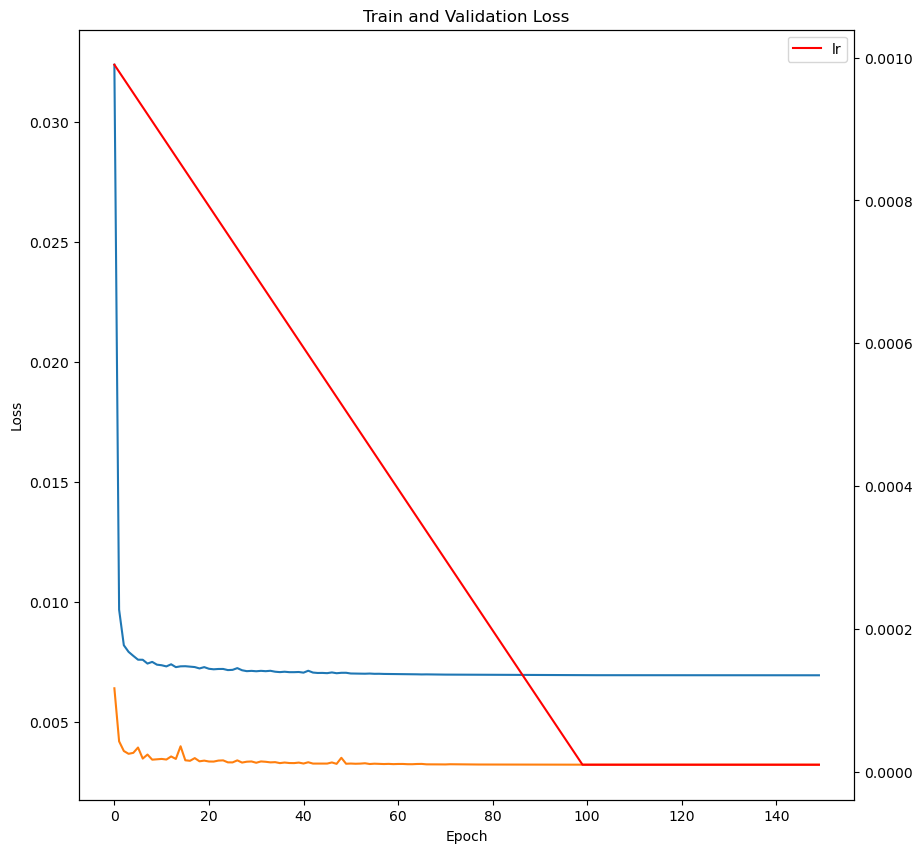

In [25]:
train_loss_array = np.array(train_loss_array)
validation_loss_array = np.array(validation_loss_array)

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111)
ax.plot(range(len(train_loss_array)), train_loss_array, label='train_loss')
ax.plot(range(len(validation_loss_array)), validation_loss_array, label='validation_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')

ax2 = ax.twinx()
ax2.plot(range(len(lr_array)), lr_array, label='lr', color='red')

plt.title('Train and Validation Loss')
plt.legend()
plt.show()

In [26]:
df = pd.DataFrame({'Train Loss': train_loss_array, 'Validation Loss': validation_loss_array, 'epoch': epoch_array, 'learning rate': lr_array, 'epoch_duration [s]': time_array})
df.head()

,Train Loss,Validation Loss,epoch,learning rate,epoch_duration [s]
0,0.032367,0.006408,0,0.000990,455.137540
1,0.009680,0.004199,1,0.000980,366.629437
2,0.008199,0.003796,2,0.000970,344.366660
3,0.007924,0.003680,3,0.000960,348.709923
4,0.007757,0.003719,4,0.000951,353.475294


In [27]:
df

,Train Loss,Validation Loss,epoch,learning rate,epoch_duration [s]
0,0.032367,0.006408,0,0.000990,455.137540
1,0.009680,0.004199,1,0.000980,366.629437
2,0.008199,0.003796,2,0.000970,344.366660
3,0.007924,0.003680,3,0.000960,348.709923
4,0.007757,0.003719,4,0.000951,353.475294
...,...,...,...,...,...
145,0.006950,0.003225,145,0.000010,352.176493
146,0.006949,0.003226,146,0.000010,337.343138
147,0.006949,0.003226,147,0.000010,330.069791
148,0.006949,0.003226,148,0.000010,326.819749


# Tesntando o modelo em uma imagem

C:\Users\Pedro\AppData\Local\Temp\ipykernel_2388\3721638021.py:5: DeprecationWarning: LINEAR is deprecated and will be removed in Pillow 10 (2023-07-01). Use BILINEAR or Resampling.BILINEAR instead.
  transforms.Resize((new_image.size[1] // 2, new_image.size[0] // 2), interpolation=Image.LINEAR),
C:\Users\Pedro\AppData\Local\Temp\ipykernel_2388\3721638021.py:7: DeprecationWarning: LINEAR is deprecated and will be removed in Pillow 10 (2023-07-01). Use BILINEAR or Resampling.BILINEAR instead.
  transforms.Resize((new_image.size[1], new_image.size[0]), interpolation=Image.LINEAR)
C:\Users\Pedro\anaconda3\lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None

(250, 361)
torch.Size([3, 361, 250])
255


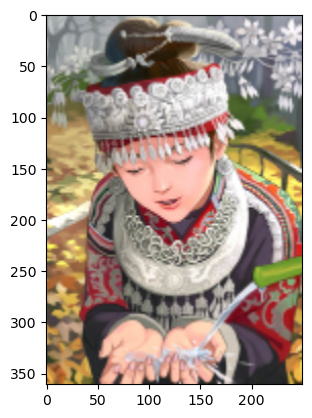

In [31]:
new_image = Image.open(f"{DATASET_ROOT}Set14/comic.png")
transform = transforms.Compose([
    transforms.ToTensor(),
    # resize image to 33x33 and downsample by BICUBIC interpolation
    transforms.Resize((new_image.size[1] // 2, new_image.size[0] // 2), interpolation=Image.LINEAR),
    # resize image to 256x256
    transforms.Resize((new_image.size[1], new_image.size[0]), interpolation=Image.LINEAR)
])

print(new_image.size)


new_image_lr = transform(new_image)
print(new_image_lr.shape)
print(np.array(new_image).max())
image_helper.show_tensor_as_image(new_image_lr) # mudar pro arquivo novo


In [36]:
# new_image.size

In [37]:
# new_image = Image.open(f"{DATASET_ROOT}/Flickr2K/000400.png")
# plt.figure()
# plt.imshow(new_image)
# plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


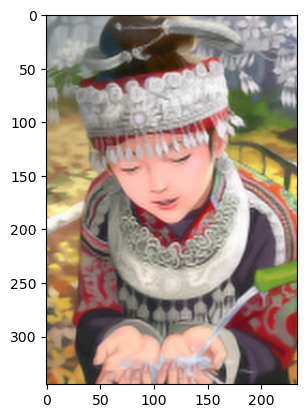

In [32]:
# import matplotlib.pyplot as plt

plt.figure()
new_image_sr = model(new_image_lr.to(device))
new_image_sr_np = new_image_sr.cpu().detach().numpy()
# new_img = torch.mul(new_image_sr, 3)
plt.imshow(new_image_sr_np.transpose((1, 2, 0)))
plt.show()

In [33]:
# model(torch.randn([3, 33, 33]).to(device))

In [34]:
# abc = torch.mul(new_image_sr, 2)
# abc_np = abc.cpu().detach().numpy()

# abc = new_image_sr
# a = model(new_img)

In [35]:
# import matplotlib.pyplot as plt

# plt.figure()
# abc = torch.mul(new_image_sr, 0.4)
# abc_np = abc.cpu().detach().numpy()
# plt.imshow(abc_np.transpose((1, 2, 0)))
# plt.show()

In [36]:
torch.save(model.state_dict(), './srcnn_13_07-v1.pth')

In [39]:
model_2 = SRCNN(num_channels=3).to(device)
try:
    model_2.load_state_dict(torch.load('./srcnn_13_07-v1.pth'))
except:
    model_2.load_state_dict(torch.load('./srcnn_13_07-v1.pth', map_location=torch.device('cpu')))

In [40]:
df.to_csv('srcnn_13_07-v1.csv')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


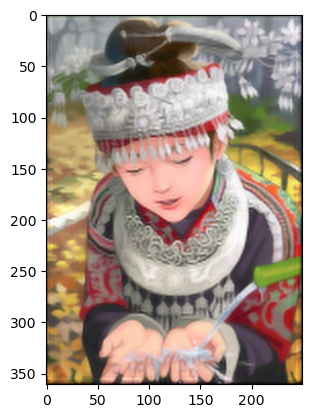

In [41]:
import matplotlib.pyplot as plt

plt.figure()
new_image_sr = model_2(new_image_lr.to(device))
new_image_sr_np = new_image_sr.cpu().detach().numpy()
plt.imshow(new_image_sr_np.transpose((1, 2, 0)))
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


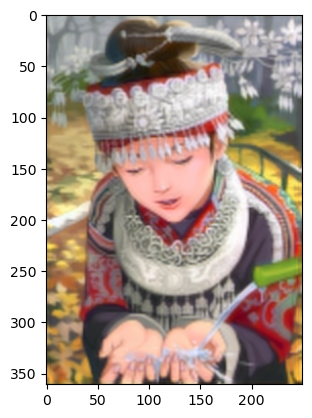

In [54]:
import matplotlib.pyplot as plt

plt.figure()
new_image_sr = model(new_image_lr.to(device))
new_image_sr_np = new_image_sr.cpu().detach().numpy()
# new_img = torch.mul(new_image_sr, 3)
plt.imshow(new_image_sr_np.transpose((1, 2, 0)))
plt.show()